In [1]:
# Analysis of RNA embeddings
# Plot sequences from dg_unique in the basis given by dg_base

import sys
import os
from tqdm import tqdm
# import requests

sys.path.append(os.path.abspath('../'))
import numpy as np
import pandas as pd
# from sklearn.neighbors import KDTree
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.decomposition import PCA
import pandas as pd
from adjustText import adjust_text
from scipy.spatial import distance

In [2]:
# Read data
path = "../data/raw/data_rna_central/general_dataframes/"

# ADD sequences of interest (PTC sequences)
files_unique = "general_rnafm_unique.csv"
dg_unique = pd.read_pickle(path+files_unique).drop(index=1).reset_index(drop=True)

# ADD random sequences
files_random = [
    "general_rnafm_random_8nucl_full.csv", # rna_data_extract_random.py
    "general_rnafm_random_10nucl_full_noN.csv", # rna_data_extract_random.py
    "general_rnafm_hairpin_9nucl_full.csv", # rna_data_extract_hairpin.py
    "general_rnafm_hairpin_tail_8nucl_full.csv", # rna_data_extract_hairpin_tail.py
    "general_rnafm_symmetric_8nucl_full.csv", # rna_data_extract_symmetric.py
    ]
dg_base = pd.read_pickle(path+files_random[0])
# filtre by length
# dg_base = dg_base[(dg_base['sequence'].str.len() > 0)&(dg_base['sequence'].str.len() <= 8)]
dg_base = dg_base.reset_index(drop=True)
#dg = dg.drop(dg.index) # make dataframe empty

# ADD sequences extracted from RNAcentral database
extract_types = ['tRNA']
extract_types = []
# files: general_rnafm_0_2000.csv, general_rnafm_2000_4000.csv, ...
max_value = 53 * 2000 # max number of RNA molecules to load (divisiable by 2000)
step = 2000 # number of RNA molecules in each file
files_db = [f"general_rnafm_{i}_{i+step}.csv" for i in range(0, max_value, step)] # files to download
N_RNA_missing = 0 # keep track of number RNAs not downloaded from RNAcentral 
if len(extract_types)>0:
    for file in tqdm(files_db):
        df = pd.read_pickle(path+file)# [N_start: N_end]
        # quatify extraction problems
        perecent_missing = 100*(100000-len(df))/100000
        N_RNA_missing += 100000 * perecent_missing / 100
        df = df.loc[df["embedding"].apply(lambda x: isinstance(x, np.ndarray))]
        df = df.loc[df.rna_type.isin(extract_types)]
        df = df.reset_index(drop=True)

        dg_base = pd.concat([dg_base, df, ], ignore_index=True)


# Concatenate dataframes of interest
#dg_base = pd.concat([dg_unique.loc[8:8], dg_unique.loc[8:8], dg_unique.loc[8:8], dg_base], ignore_index=True)
#dg_base = pd.concat([dg_unique, dg_base], ignore_index=True)
#dg_base = dg_base.loc[dg_base.rna_type!="SymR_PA"]
dg_base = dg_base.reset_index(drop=True)
    
print("N_RNA_missing ", int(N_RNA_missing))
print("length of dg:", len(dg_base), "RNA molecules")
print("rna types:", pd.Series(dg_base.rna_type).unique())


N_RNA_missing  0
length of dg: 488280 RNA molecules
rna types: ['random']


In [ ]:
# Decrease dataframe size
# Keep only random L rows for each rna type
L = 500000  

# Select up to L rows per group
dg_base = dg_base.groupby("rna_type").apply(lambda x: x.sample(n=min(L, len(x)), random_state=42)).reset_index(drop=True)

print(len(dg_base))
print("rna types:", pd.Series(dg_base.rna_type).unique())

In [ ]:
# use only 'symmetric_abab' sequences
#dg_base = dg_base.loc[dg_base['rna_type']=='symmetric_abab'].reset_index(drop=True)
#dg_base.tail(2)

In [ ]:
# Remove all RNAs with arbitrary nucleotides ("N"), if needed
# dg_base = dg_base[~dg_base['sequence'].str.contains('N', case=False, na=False)].reset_index(drop=True)


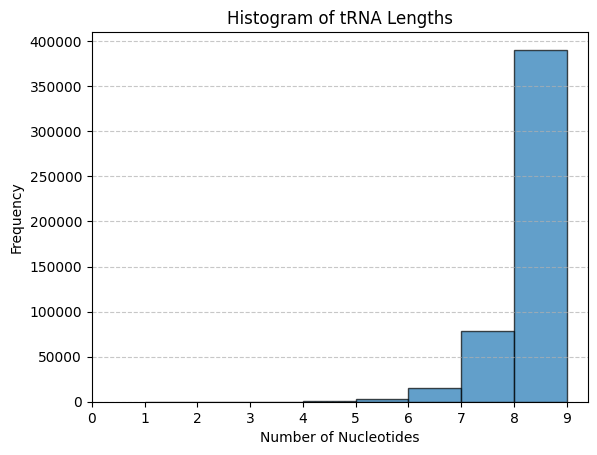

In [3]:
# Plot histogram of lengths for dg_base basis

step = 1  # Adjust as needed
lengths = dg_base['sequence'].str.len().tolist()
Xmax = max(lengths)
# plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), edgecolor='black', alpha=0.7)
plt.hist(lengths, bins=range(min(lengths), Xmax + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Nucleotides')
plt.ylabel('Frequency')
plt.title('Histogram of tRNA Lengths')

# Set x-axis ticks with step size
plt.xticks(range(0, Xmax + 2, step))
#plt.xticks(range(0, 150 + 3, step))

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [ ]:
# Calculate dimentionality reduction

# flag = 0 for UMAP or 1 for PCA
flag = 0
n_components = 3 # 2 or 3, take care of correct 2D and 3D plots below!

vectors_base = np.stack(dg_base["embedding"].values)
vectors_check = np.stack(dg_unique["embedding"].values)
print("Before dimentionality reduction:", vectors_base.shape)

if flag==0:
    #umap_model = umap.UMAP(n_neighbors=50, min_dist=0.01, n_components=3)
    umap_model = umap.UMAP(n_components=n_components, random_state=42, n_jobs=-1)
    vectors_base_fitT = umap_model.fit_transform(vectors_base)
    print("After UMAP dimentionality reduction:", vectors_base_fitT.shape)
    vectors_check_T = umap_model.transform(vectors_check) 
else:
    pca_model = PCA(n_components=n_components, random_state=42)
    vectors_base_fitT = pca_model.fit_transform(vectors_base)
    print("After PCA dimentionality reduction:", vectors_base_fitT.shape)
    vectors_check_T = pca_model.transform(vectors_check) 



Before dimentionality reduction: (488280, 640)


c:\Users\User\miniconda3\envs\rna\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\miniconda3\envs\rna\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


After UMAP dimentionality reduction: (488280, 3)


c:\Users\User\miniconda3\envs\rna\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


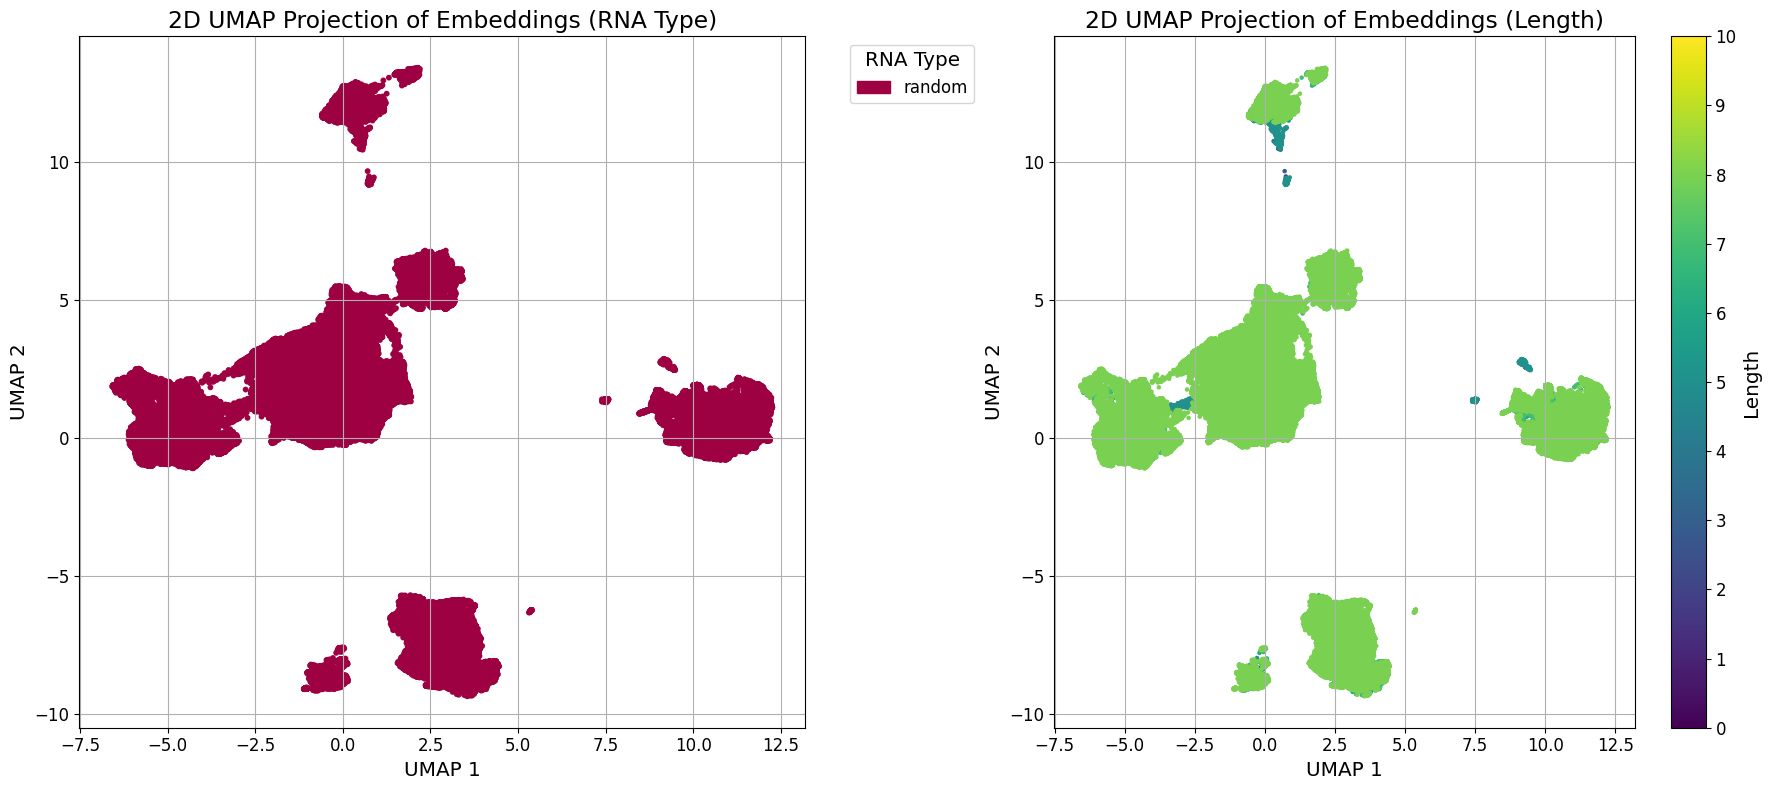

In [5]:
# Make 2D plot after dimensionality reduction

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Define scaling factor for font sizes (20% increase)
scale_factor = 1.2

# First plot: Colored by `rna_type`
ax1 = axes[0]
rna_types = pd.Series(dg_base['rna_type']).astype('category')
rna_codes = rna_types.cat.codes  # Numeric codes for categories
cmap = plt.cm.Spectral  # Colormap
norm = plt.Normalize(vmin=rna_codes.min(), vmax=rna_codes.max())  # Normalize color scale

scatter1 = ax1.scatter(vectors_base_fitT[:, 0], vectors_base_fitT[:, 1], c=rna_codes, cmap=cmap, norm=norm, s=10)
ax1.set_title('2D UMAP Projection of Embeddings (RNA Type)', fontsize=14 * scale_factor)
ax1.set_xlabel('UMAP 1', fontsize=12 * scale_factor)
ax1.set_ylabel('UMAP 2', fontsize=12 * scale_factor)
ax1.tick_params(axis='both', labelsize=10 * scale_factor)  # Scale tick labels
ax1.grid(True)

# Create a legend with consistent colors
unique_rna_types = rna_types.cat.categories
patches = [mpatches.Patch(color=cmap(norm(code)), label=rna_type) 
           for rna_type, code in zip(unique_rna_types, range(len(unique_rna_types)))]

legend = ax1.legend(handles=patches, title="RNA Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10 * scale_factor)
legend.get_title().set_fontsize(12 * scale_factor)  # Scale legend title

# Second plot: Colored by `length`
# Compute sequence lengths
sequence_lengths = np.array([len(seq) for seq in dg_base['sequence']])
ax2 = axes[1]

# Use percentiles to remove extreme outliers
vmin, vmax = np.percentile(sequence_lengths, [0, 100])

# Round vmin and vmax to nearest multiple of 10
vmin = int(np.floor(vmin / 10) * 10)
vmax = int(np.ceil(vmax / 10) * 10)

# **Adaptive Step Calculation**: Adjust step size based on range
value_range = vmax - vmin

if value_range <= 10:
    step = 1  # Small range → keep step small
elif value_range <= 100:
    step = 10  # Small range → keep step small
elif value_range <= 500:
    step = 25  # Moderate range → increase step
elif value_range <= 2000:
    step = 50  # Large range → bigger step
else:
    step = 100  # Very large range → even bigger step

# Normalize colors based on adjusted range
norm = plt.Normalize(vmin=vmin, vmax=vmax)

scatter2 = ax2.scatter(vectors_base_fitT[:, 0], vectors_base_fitT[:, 1], c=sequence_lengths, cmap='viridis', norm=norm, s=5)
ax2.set_title('2D UMAP Projection of Embeddings (Length)', fontsize=14 * scale_factor)
ax2.set_xlabel('UMAP 1', fontsize=12 * scale_factor)
ax2.set_ylabel('UMAP 2', fontsize=12 * scale_factor)
ax2.tick_params(axis='both', labelsize=10 * scale_factor)  # Scale tick labels
ax2.grid(True)

# Add color bar with adjusted scaling
cbar = plt.colorbar(scatter2, ax=ax2)
cbar.set_label('Length', fontsize=12 * scale_factor)
cbar.ax.tick_params(labelsize=10 * scale_factor)  # Scale color bar ticks

# Generate tick marks with adaptive step size
tick_values = np.arange(vmin, vmax + 1, step)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([str(int(tick)) for tick in tick_values])  # Ensure integer labels

plt.tight_layout()
plt.show()

In [6]:
# 2D case
# pLot vectors not participating in transform

sequence_names = dg_unique["rna_type"].tolist()
vectors0 = []
for i,el in enumerate(vectors_check_T):
    vectors0.append((sequence_names[i], (0, 0, el[0], el[1])))
vectors0 = vectors0[:8]

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


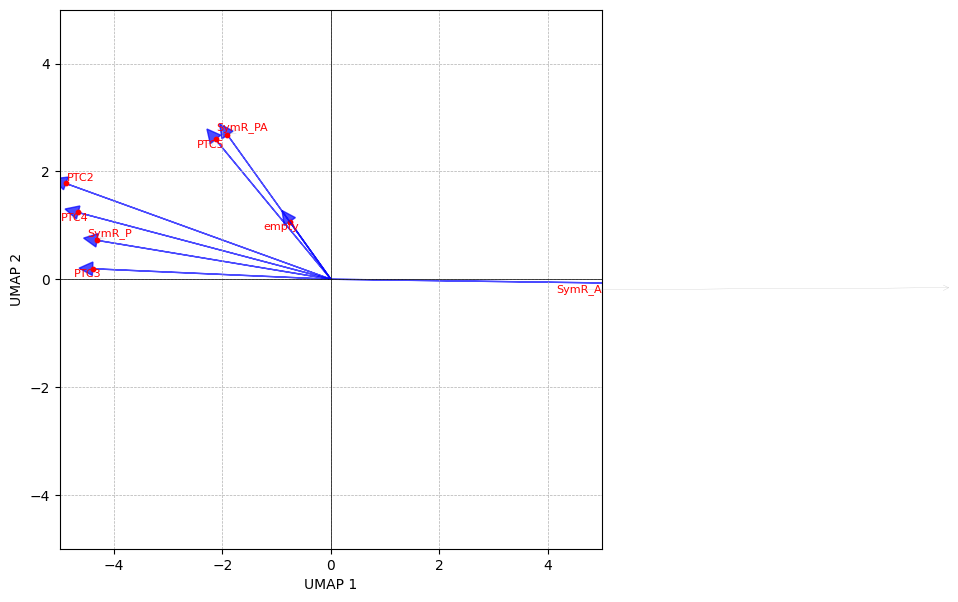

In [7]:
# 2D case

# Create a plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(True, linestyle='--', linewidth=0.5)

texts = []  # Store text elements for later adjustment

for label, (x_start, y_start, x_end, y_end) in vectors0:
    dx = x_end - x_start
    dy = y_end - y_start
    
    ax.arrow(x_start, y_start, dx, dy, head_width=0.25, head_length=0.25, fc='blue', ec='blue', alpha=0.7)
    ax.scatter(x_end, y_end, color='red', s=10) # s is size of red point
    
    # Create a text label and store it in the list for adjustment
    text = ax.text(x_end, y_end, label, fontsize=8, ha='center', va='center', color='red', fontweight='normal')
    texts.append(text)

# Adjust text labels to avoid overlaps
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.1))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.1),
            expand_points=(1.5, 1.5),  # Increase this value to push labels further
            force_points=(0.3, 0.3),  # Apply a small force to move labels away from points
            force_text=(0.1, 0.1))  # Apply a small force between labels

# ax.set_title("Labeled Vectors Plot with Adjusted Labels")
ax.set_xlabel("UMAP 1", fontsize=10)  # Set x-axis label
ax.set_ylabel("UMAP 2", fontsize=10)  # Set y-axis label
plt.show()


In [8]:
# 3D case
# pLot vectors not participating in transform

sequence_names = dg_unique["rna_type"].tolist()
vectors0 = []
for i,el in enumerate(vectors_check_T):
    vectors0.append((sequence_names[i], (0, 0, 0, el[0], el[1], el[2])))
vectors0 = vectors0[:8]

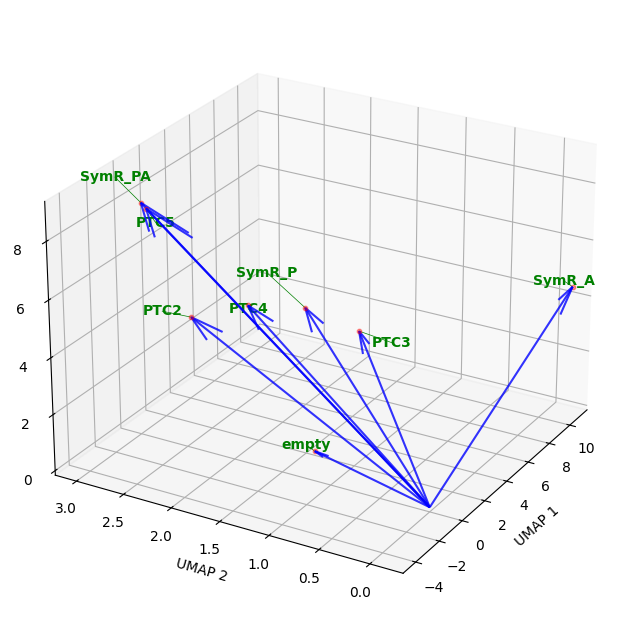

In [9]:
# 3D case
# create a plot
# Example vectors: (label, (x_start, y_start, z_start, x_end, y_end, z_end))

# Create figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Set axis labels  
ax.set_xlabel("UMAP 1", fontsize=10)
ax.set_ylabel("UMAP 2", fontsize=10)
ax.set_zlabel("UMAP 3", fontsize=10)

# Fix camera angle
ax.view_init(elev=25, azim=20+180+35+45+15+45+35+10+45+135+95-90)

# Extract vector start and end points
startpoints = np.array([vec[1][:3] for vec in vectors0], dtype=float)
endpoints = np.array([vec[1][3:] for vec in vectors0], dtype=float)

# Compute initial label positions (slightly offset from endpoints)
label_positions = endpoints + 0.1

# Adjust labels to avoid overlap
def adjust_labels(positions, sizes, min_distance=0.2, max_iterations=200):
    positions = positions.copy()  # Avoid modifying original array
    for _ in range(max_iterations):
        moved = False
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                dist = distance.euclidean(positions[i], positions[j])
                required_dist = min_distance + sizes[i] + sizes[j]
                
                if dist < required_dist:
                    direction = positions[i] - positions[j]
                    norm = np.linalg.norm(direction)
                    if norm == 0:
                        direction = np.random.rand(3)  # Random small shift if identical
                    else:
                        direction /= norm
                    
                    move_step = (required_dist - dist) * 0.8  # Move labels apart more aggressively
                    positions[i] += direction * move_step
                    positions[j] -= direction * move_step
                    moved = True
        if not moved:
            break
    return positions

# Compute label sizes based on text length
label_sizes = np.array([len(vec[0]) * 0.1 for vec in vectors0])

# Adjust label positions to remove overlap
label_positions = adjust_labels(label_positions, label_sizes)

# Plot vectors and labels
for (label, (x_start, y_start, z_start, x_end, y_end, z_end)), (new_x, new_y, new_z) in zip(vectors0, label_positions):
    dx, dy, dz = x_end - x_start, y_end - y_start, z_end - z_start
    ax.quiver(x_start, y_start, z_start, dx, dy, dz, color='blue', alpha=0.8, arrow_length_ratio=0.1)
    ax.scatter(x_end, y_end, z_end, color='red', s=10, alpha=0.4)
    
    # Draw solid green line connecting endpoint to adjusted label position
    ax.plot([x_end, new_x], [y_end, new_y], [z_end, new_z], color='green', linestyle='solid', linewidth=0.5)
    
    # Place text label
    ax.text(new_x, new_y, new_z, label, fontsize=10, ha='center', va='center', color='green', fontweight='bold')

# ✅ **NEW: Smart axis adjustment**
# Calculate the actual min and max points from all endpoints and labels
all_points = np.vstack([startpoints, endpoints, label_positions])
mins, maxs = np.min(all_points, axis=0), np.max(all_points, axis=0)

# Compute spread (range) per axis and find the largest one
spreads = maxs - mins
max_spread = np.max(spreads)

# Extend limits based on actual spread, keeping balance
padding = max_spread * 0.01  # 20% extra space
ax.set_xlim(mins[0] - padding, maxs[0] + padding)
ax.set_ylim(mins[1] - padding, maxs[1] + padding)
ax.set_zlim(mins[2] - padding, maxs[2] + padding)

plt.show()

